## Install libraries

In [1]:
!pip install numpy pandas geopandas earthengine-api rasterio fiona

### Read 'EcoParques' layer

In [2]:
import os
import sagemaker
import boto3
import geopandas as gpd
import time
import numpy as np
## import pandas as pd
## import geopandas as gpd
from scipy import stats
import geemap
import folium

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
%%time
# Leer shp
bucket_name = 'bucket-lcid-2'
file_key = "geoMedellin-layers/ecoParques/ecoparques.shp"

s3_path = f's3://{bucket_name}/{file_key}'
gdf = gpd.read_file(s3_path)


CPU times: user 151 ms, sys: 16.3 ms, total: 167 ms
Wall time: 719 ms


In [4]:
gdf.head(2)

,nombre,quebrada_a,dominio,funcion,categoria,subcategor,jerarquia,orden,direccion_,cbml,id_zona,accion,Shape_Leng,Shape_Area,geometry
0,Ecoparque La Quintana 2,Q. La Quintana,Bienes de uso público,Parques,Ecoparque,Ecoparque de quebrada y otros cuerpos de agua,Nivel Comunal/ Suburbano Nivel 1,Local,Carrera 88 84,07120800009,29,Mantenimiento,1223.121921,34174.936602,"MULTIPOLYGON (((4713614.041 2253927.683, 47136..."
1,Ecoparque La Iguana,Q. La Iguaná,Bienes de uso público,Parques,Ecoparque,Ecoparque de quebrada y otros cuerpos de agua,Nivel Comunal/ Suburbano Nivel 1,Local,Calle 57 65,11010290001,9,Mantenimiento,1132.874169,23159.849225,"POLYGON ((4714961.989 2250302.481, 4714991.85 ..."


In [5]:
import rasterio
import numpy as np
import ee

In [6]:
ee.Authenticate()

True

In [7]:
# Initialize the Earth Engine API
ee.Initialize()

# Load the shapefile and raster data from local storage
## shapefile_path = 'path/to/your_shapefile.shp'
## raster_path = 'path/to/your_raster.tif'

# Leer raster
## bucket_name = 'bucket-lcid-2'
## year = '2020'
## image_key = "image-data-files-ee/geomediana_medellin_"+year+".tif"

## raster_path = f's3://{bucket_name}/{image_key}'

img_2020 = ee.Image('users/eeranyartrodrigo/geomediana_medellin_2020')
img_2021 = ee.Image('users/eeranyartrodrigo/geomediana_medellin_2021')
img_2022 = ee.Image('users/eeranyartrodrigo/geomediana_medellin_2022')
img_2023 = ee.Image('users/eeranyartrodrigo/geomediana_medellin_2023')
img_2024 = ee.Image('users/eeranyartrodrigo/geomediana_medellin_2024')
img_col = ee.ImageCollection([img_2020, img_2021, img_2022, img_2023, img_2024])

In [8]:
## Read Ecoparques Layers directly from GEE to improve speed in calculations
feat_col = ee.FeatureCollection('users/eeranyartrodrigo/datathonMedellin/ecoparques')

### Compute NDVI for each geomedian
*Two different approaches to choose from*

In [9]:
%%time
images = [img_2020, img_2021, img_2022, img_2023, img_2024]
ndvi = []
for img in images:
    ndvi.append(img.normalizedDifference(['B8','B4']).rename(['NDVI']))
print(ndvi[0].getInfo())

{'type': 'Image', 'bands': [{'id': 'NDVI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [2241, 3185], 'crs': 'EPSG:4326', 'crs_transform': [8.983152841195215e-05, 0, -75.66833031641012, 0, -8.983152841195215e-05, 6.381721609913493]}], 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-75.46697301863259, 6.095641860619365], [-75.46697230752712, 6.095653075118624], [-75.46697221863893, 6.381676708219498], [-75.46700901834267, 6.381718176062716], [-75.46704030697256, 6.381763827490024], [-75.46705515129185, 6.3817666995159845], [-75.66828537526133, 6.381766659910279], [-75.66832709581412, 6.381730077253331], [-75.66837307717547, 6.3816989865743725], [-75.66837591772241, 6.381684215499939], [-75.66837591772241, 6.095653142756292], [-75.66833907937495, 6.095611658968881], [-75.66830783334763, 6.09556592328379], [-75.66829673745563, 6.095563815671451], [-75.66828537526133, 6.095563116058856], [-75.46706279567125, 6.0955

In [10]:
%%time
def computeNDVI(image):
    return image.normalizedDifference(['B8','B4']).rename(['ndvi'])
ndvi_col = img_col.map(computeNDVI)

CPU times: user 658 μs, sys: 0 ns, total: 658 μs
Wall time: 662 μs


### Compute the basic statistics of NDVI
*Iterate over each 'Ecoparque' polygon and extract its statistics*

In [11]:
%%time
def computeReductions(feature):
    geom = feature.geometry()
    minimums = []
    maximums = []
    means = []
    medians = []
    for img in ndvi:
        minimums.append(img.reduceRegion(geometry=geom, scale=10, reducer=ee.Reducer.min()).get('NDVI'))
        maximums.append(img.reduceRegion(geometry=geom, scale=10, reducer=ee.Reducer.max()).get('NDVI'))
        means.append(img.reduceRegion(geometry=geom, scale=10, reducer=ee.Reducer.mean()).get('NDVI'))
        medians.append(img.reduceRegion(geometry=geom, scale=10, reducer=ee.Reducer.median()).get('NDVI'))
    return ee.Feature(geom).set({'nombre':feature.get('nombre'), 'min':minimums, 'max':maximums, 'means':means, 'medians':medians})
ecoparques_ndvi_reductions = feat_col.map(computeReductions)

CPU times: user 4.64 ms, sys: 68 μs, total: 4.71 ms
Wall time: 4.67 ms


In [12]:
ecoparques_ndvi_reductions.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-75.56882108864052, 6.277144958946384],
    [-75.56865888975622, 6.276979690085331],
    [-75.56861829559357, 6.276939455619278],
    [-75.56862726717095, 6.2769349767972615],
    [-75.56859573340644, 6.276908160181758],
    [-75.56867194739479, 6.2769078479835185],
    [-75.56865409307237, 6.276916886941837],
    [-75.56866306464758, 6.276930302277033],
    [-75.56867203622227, 6.276925744624756],
    [-75.56870339231558, 6.276907623804063],
    [-75.56869415426044, 6.276867320384489],
    [-75.56870312583324, 6.276867255976714],
    [-75.56868962406013, 6.276849378376479],
    [-75.56868056365906, 6.276831467336617],
    [-75.56867603345833, 6.27683149829879],
    [-75.5686445885317, 6.276804763053447],
    [-75.56860861339558, 6.276791459664489],
    [-75.56858169865836, 6.276787080824947],
    [-75.56860372788259, 6.27671068132565],
    [-75.56859466747625, 6.276697263564689],
    [-75.56856819687417, 6.276787

## Display image and collection over a map

In [13]:
!pip install --upgrade packaging
!pip install pyperclip
!pip install geemap
!pip install jupyter-leaflet

In [14]:

# Define the ee.Image and ee.FeatureCollection
base_image = img_2024.select(['B4', 'B3', 'B2']).divide(10000)
ecoparques = ecoparques_ndvi_reductions  # Replace with actual path

# Visualization parameters
image_vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2']
}

feature_vis_params = {
    'color': 'red'
}

# Create a folium map centered around the FeatureCollection
center = ecoparques_ndvi_reductions.geometry().centroid().coordinates().getInfo()
m = folium.Map(location=[center[1], center[0]], zoom_start=12)

# Get the map ID for the base image
map_id_dict = base_image.getMapId(image_vis_params)

# Create the tile layer from the map ID
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Base Image',
    overlay=True,
    control=True
).add_to(m)

# Convert the FeatureCollection to GeoJSON and add it to the map
geojson = geemap.ee_to_geojson(ecoparques_ndvi_reductions)
folium.GeoJson(geojson, style_function=lambda x: {'color': 'red', 'weight': 2}).add_to(m)

# Display the map
m

### Convert featureCollection into geopandas

In [15]:
%%time
# Convert the FeatureCollection to a GeoJSON format by calling getInfo()
geojson = ecoparques_ndvi_reductions.getInfo()

# Convert the GeoJSON to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson['features'])


CPU times: user 37 ms, sys: 3.63 ms, total: 40.7 ms
Wall time: 2.92 s


In [16]:
# Print the GeoDataFrame to check the data
gdf.head(100)

,geometry,max,means,medians,min,nombre
0,"POLYGON ((-75.56882 6.27714, -75.56866 6.27698...","[0.7436392914653784, 0.7045309508615188, 0.777...","[0.4528189964176856, 0.4292616657958703, 0.304...","[0.477620208454226, 0.4560746611144321, 0.2833...","[0.03775019001773499, 0.031204794379003926, -0...",Parque Ambiental Morro Moravia
1,"POLYGON ((-75.53903 6.24107, -75.53903 6.24107...","[0.788421297372704, 0.655724993538382, None, 0...","[0.5610483232893546, 0.438410184841298, None, ...","[0.633986191065908, 0.5066877147516797, None, ...","[0.04944649446494465, 0.023191823899371068, No...",Ecoparque Campo Santo Villatina
2,"POLYGON ((-75.54457 6.22575, -75.54455 6.22572...","[0.8762533626803619, 0.822426010837849, None, ...","[0.8153419789146271, 0.7480362411449566, None,...","[0.8261901991335572, 0.7524722456905891, None,...","[0.6634159933129006, 0.6652173913043479, None,...",Ecoparque Caunces de Oriente
3,"POLYGON ((-75.52869 6.23905, -75.52868 6.23903...","[0.8324518722233974, 0.6622889305816135, None,...","[0.6448929913206436, 0.39907829206921913, None...","[0.6666707257962461, 0.3879444096620309, None,...","[0.3289248101885868, 0.19881512458616485, None...",Ecoparque Villa Turbay
4,GEOMETRYCOLLECTION (LINESTRING (-75.5642 6.237...,"[0.8462957270212111, 0.8870967741935484, 0.915...","[0.7125128273951917, 0.7395816024478223, 0.783...","[0.7519191890064707, 0.7752222579013998, 0.826...","[0.01175680214981525, 0.10844629822732013, 0.0...",Área de Recreación Urbana Cerro La Asomadera
...,...,...,...,...,...,...
76,"POLYGON ((-75.65434 6.18271, -75.65433 6.1827,...","[0.8032608695652174, 0.8239583333333333, 0.847...","[0.6405499762330631, 0.7162849398495849, 0.667...","[0.7209782070397343, 0.759974991402721, 0.7064...","[0.19777872703972663, 0.3392316647264261, 0.26...",Ecoparque La Manguala - La Riviera 1
77,"POLYGON ((-75.65295 6.1804, -75.65277 6.1803, ...","[0.8456449834619625, 0.8736167734420501, 0.871...","[0.7583699633646134, 0.7768207911182979, 0.775...","[0.7759275325017618, 0.7989410854683052, 0.798...","[0.31094452773613196, 0.3244444444444444, 0.37...",Ecoparque La Manguala - La Riviera 2
78,"POLYGON ((-75.61991 6.28234, -75.61982 6.28224...","[0.800278940027894, 0.7964137931034483, 0.8244...","[0.6710878217697277, 0.6947995619900066, 0.713...","[0.6934044082985552, 0.708317965493336, 0.7398...","[0.32429718875502006, 0.37412685107571947, 0.2...",Ecoparque El Chagualon
79,"POLYGON ((-75.61205 6.28156, -75.61204 6.28152...","[0.824223602484472, 0.8379152348224513, 0.8430...","[0.666410088735762, 0.7107959533253723, 0.6904...","[0.6780335305742373, 0.7244896459725668, 0.705...","[0.3056646102075154, 0.38326954620010933, 0.16...",Ecoparque Mirador del Valle


## Linear Regression in NDVI values to discover trends
+ Perform a linear regression to discover the trend in NDVI for each 'ecoparque'
+ A negative slope indicates a possible loss in vegetation's health

*None values occur when the image does not contain valid values, perform the linear regression with the remainder of values*

In [47]:
%%time
## add Time values for the regression
x_values = np.array([2020, 2021, 2022, 2023, 2024])

## this arrays will store all the slopes and intercepts
## to choose one ecopark use a 81-size slide in each array
model_slope = []
model_intercept = []


# Function to compute the slope of the linear model for each feature
def compute_slope(values):
    valid_indices = [i for i, value in enumerate(values) if value is not None]
    if not valid_indices:
        return None  # Return None if all values are None
    
    # Filter the years and 'means' values to include only valid data points
    X_clean = x_values[valid_indices]
    y_clean = np.array([values[i] for i in valid_indices])

    # Perform linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(X_clean, y_clean)
    ## save slopes and intercepts for plot purposes
    model_slope.append(slope)
    model_intercept.append(intercept)
    return slope


## Mapping the function to the data
gdf['means_slope'] = gdf['means'].apply(compute_slope)
gdf['medians_slope'] = gdf['medians'].apply(compute_slope)
gdf['min_slope'] = gdf['max'].apply(compute_slope)
gdf['max_slope'] = gdf['min'].apply(compute_slope)

print(gdf[['means_slope','medians_slope','min_slope','max_slope']])

    means_slope  medians_slope  min_slope  max_slope
0     -0.073942      -0.091773  -0.004296  -0.010619
1     -0.008277      -0.006096   0.006791  -0.011813
2     -0.021702      -0.016281  -0.002841  -0.083754
3      0.033527       0.036418   0.022410  -0.003629
4      0.008299       0.008231   0.005074  -0.000036
..          ...            ...        ...        ...
76     0.010591       0.004323   0.002642   0.019079
77    -0.006577      -0.003990   0.000819  -0.029482
78     0.012783       0.012928   0.012339  -0.012875
79     0.008138       0.009675   0.003591  -0.044241
80    -0.006615      -0.006338   0.001482  -0.026165

[81 rows x 4 columns]
CPU times: user 286 ms, sys: 0 ns, total: 286 ms
Wall time: 285 ms


### Count how many 'ecoparques' are decreasing or increasing its NDVI values

In [48]:
# Count positive and negative values in the 'means_slope', 'max_slope', 'min_slope', and 'medians_slope' columns
columns = ['means_slope', 'medians_slope', 'max_slope', 'min_slope']

# Initialize a dictionary to store the counts
slope_counts = {}

# Iterate over the columns and count positive and negative values
for col in columns:
    pos_count = (gdf[col] > 0).sum()  # Count values greater than 0
    neg_count = (gdf[col] < 0).sum()  # Count values less than 0
    slope_counts[col] = {'positive': pos_count, 'negative': neg_count}

# Print the results
for col, counts in slope_counts.items():
    print(f"Column: {col} - Positive: {counts['positive']}, Negative: {counts['negative']}")


Column: means_slope - Positive: 61, Negative: 20
Column: medians_slope - Positive: 63, Negative: 18
Column: max_slope - Positive: 39, Negative: 42
Column: min_slope - Positive: 61, Negative: 20


In [21]:
# Find the index of the most negative value in the 'medians_slope' column
most_negative_median_trend = gdf['medians_slope'].idxmin()
most_negative_mean_trend = gdf['means_slope'].idxmin()

# Fetch the whole row corresponding to the most negative value
most_negative_median = gdf.loc[most_negative_median_trend]
# Display the row data
print('Most negative median: ', most_negative_median)


most_negative_mean = gdf.loc[most_negative_mean_trend]
print('Most negative mean: ', most_negative_mean)

Most negative median:  geometry         POLYGON ((-75.56882108864052 6.277144958946384...
max              [0.7436392914653784, 0.7045309508615188, 0.777...
means            [0.4528189964176856, 0.4292616657958703, 0.304...
medians          [0.477620208454226, 0.4560746611144321, 0.2833...
min              [0.03775019001773499, 0.031204794379003926, -0...
nombre                              Parque Ambiental Morro Moravia
means_slope                                              -0.073942
medians_slope                                            -0.091773
min_slope                                                -0.004296
max_slope                                                -0.010619
Name: 0, dtype: object
Most negative mean:  geometry         POLYGON ((-75.56882108864052 6.277144958946384...
max              [0.7436392914653784, 0.7045309508615188, 0.777...
means            [0.4528189964176856, 0.4292616657958703, 0.304...
medians          [0.477620208454226, 0.4560746611144321, 0.283

### Sort data to obtain the 5 'ecoparques' with the most negative median trend in NDVI

In [22]:
## gdf.to_file('ecoparques_with_ndvi_2020_2024_trends.shp')
# Sort the GeoDataFrame by 'medians_slope' in ascending order (most negative first)
sorted_gdf = gdf.sort_values(by='medians_slope', ascending=True)

# Fetch the top 5 rows with the most negative values
top_5_negative_rows = sorted_gdf.head(5)
top_5_negative_rows
# Display the top 5 rows
## print(top_5_negative_rows)

,geometry,max,means,medians,min,nombre,means_slope,medians_slope,min_slope,max_slope
0,"POLYGON ((-75.56882 6.27714, -75.56866 6.27698...","[0.7436392914653784, 0.7045309508615188, 0.777...","[0.4528189964176856, 0.4292616657958703, 0.304...","[0.477620208454226, 0.4560746611144321, 0.2833...","[0.03775019001773499, 0.031204794379003926, -0...",Parque Ambiental Morro Moravia,-0.073942,-0.091773,-0.004296,-0.010619
72,"POLYGON ((-75.65308 6.17809, -75.65307 6.17801...","[0.8074534161490683, 0.8731068358575522, 0.859...","[0.6463230040069936, 0.729029963698665, 0.6050...","[0.6727323445699052, 0.7660377358490567, 0.594...","[0.37389317337903455, 0.4157608695652174, 0.22...",Ecoparque La Cabuyala,-0.021002,-0.035202,0.004821,-0.017603
22,"MULTIPOLYGON (((-75.55327 6.3026, -75.55325 6....","[0.6138125440451022, 0.5321158690176322, 0.572...","[0.47772695350296174, 0.4065250331502246, 0.45...","[0.4990859232175503, 0.4344528710725894, 0.424...","[0.2408906882591093, 0.26396917148362237, 0.31...",Ecoparque El Míster 2,-0.014004,-0.023406,-0.013599,0.012339
2,"POLYGON ((-75.54457 6.22575, -75.54455 6.22572...","[0.8762533626803619, 0.822426010837849, None, ...","[0.8153419789146271, 0.7480362411449566, None,...","[0.8261901991335572, 0.7524722456905891, None,...","[0.6634159933129006, 0.6652173913043479, None,...",Ecoparque Caunces de Oriente,-0.028161,-0.021352,-0.003945,-0.107576
18,"MULTIPOLYGON (((-75.56078 6.28739, -75.56076 6...","[0.5250412768299395, 0.47580884535470463, 0.40...","[0.3321259548483763, 0.3045192820689392, 0.269...","[0.31238915632125663, 0.30045871559633025, 0.2...","[0.19912335629304947, 0.14192919779149074, 0.0...",Ecoparque El Aguacate,-0.022435,-0.017682,-0.032123,-0.018410


## Create a .gif file from NDVI collection

In [80]:
# Fetch the geometry for the desired ecopark
## ecoparque_morro = feat_col.filter(ee.Filter.eq('nombre', 'Parque Natural Metropolitano Cerro El Volador')).first()
ecoparque_morro = feat_col.filter(ee.Filter.eq('nombre', 'Ecoparque Cerro Tres Cruces')).first()
## Área de Recreación Parque Ecológico Cerro Nutib
## Ecoparque Cerro Tres Cruces
region = ecoparque_morro.geometry()

# Set visualization parameters for the GIF
vis_params = {
    'min': -0.35,
    'max': 1, 
    'bands': ['ndvi'],
    #'palette': ['red','orange','yellow','green'],
    #'palette': ['#640000','#ff0000','#ffff00','#00c800','lime','#006400'],
    'palette': ['#000000','#a50026','#d73027','#f46d43','#fdae61','#fee08b','#ffffbf','#d9ef8b','#a6d96a','#66bd63','#1a9850','#006837'],
    'dimensions': 1000,
    'framesPerSecond': 1,
    'format': 'gif',
    #'scale': 10,
    'region': region
}

# Generate the GIF URL
gif_url = ndvi_col.getVideoThumbURL(vis_params)
print("GIF URL:", gif_url)



GIF URL: https://earthengine.googleapis.com/v1/projects/527984288690/videoThumbnails/d1cadd41d94e3dfe2db0f19e52a1c2d9-c410560957958212f4bd51d42bfd860e:getPixels


In [24]:
ndvi_col

In [33]:
morro_moravia = gdf.iloc[0]
print(morro_moravia)

geometry         POLYGON ((-75.56882108864052 6.277144958946384...
max              [0.7436392914653784, 0.7045309508615188, 0.777...
means            [0.4528189964176856, 0.4292616657958703, 0.304...
medians          [0.477620208454226, 0.4560746611144321, 0.2833...
min              [0.03775019001773499, 0.031204794379003926, -0...
nombre                              Parque Ambiental Morro Moravia
means_slope                                              -0.073942
medians_slope                                            -0.091773
min_slope                                                -0.004296
max_slope                                                -0.010619
Name: 0, dtype: object


### Print NDVI mean and median trends for the Morro Moravia Ecopark

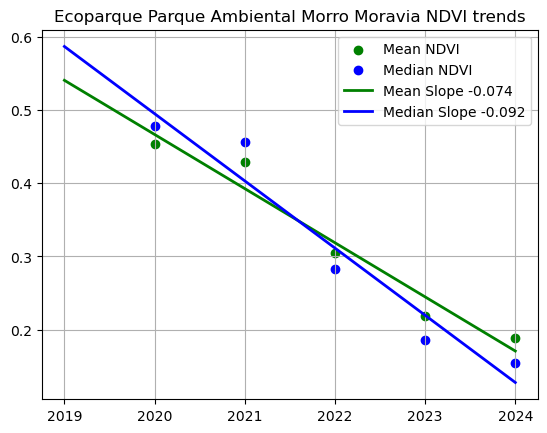

In [70]:
import matplotlib.pyplot as plt

x = range(2019, 2025, 1)
years = [2020,2021,2022,2023,2024]
mean_model_slope = model_slope[0]
mean_model_intercept = model_intercept[0]

median_model_slope = model_slope[81]
median_model_intercept = model_intercept[81]

y_mean = mean_model_slope*x + mean_model_intercept
y_median = median_model_slope*x + median_model_intercept


plt.scatter(years,morro_moravia['means'], c='green', label='Mean NDVI')
plt.scatter(years,morro_moravia['medians'], c='blue', label='Median NDVI')
plt.plot(x, y_mean, 'g-', linewidth=2, label=f'Mean Slope {np.round(mean_model_slope,3)}')
plt.plot(x, y_median, 'b-', linewidth=2, label=f'Median Slope {np.round(median_model_slope,3)}')
plt.title('Ecoparque Parque Ambiental Morro Moravia NDVI trends')
plt.grid()
plt.legend()
plt.show()

In [75]:
mean_model_intercept

149.82854176267367

### Save Information into .csv file format

In [41]:
# Drop the geometry column
gdf_no_geometry = gdf.drop(columns="geometry")

# Save the GeoDataFrame as a CSV file
output_csv_path = "ecoparques_ndvi_trends.csv"  # Specify your file path here
gdf_no_geometry.to_csv(output_csv_path, index=False)

print(f"GeoDataFrame saved successfully to {output_csv_path} without geometry column.")


GeoDataFrame saved successfully to ecoparques_ndvi_trends.csv without geometry column.


In [38]:
# Check if the geometry type is consistent
print(gdf.geom_type.unique())  # Ensure there are no mixed geometries (e.g., 'Polygon', 'LineString')


['Polygon' 'GeometryCollection' 'MultiPolygon']
